In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as ipw
import tensorflow as tf
from ipywidgets import interactive
from tensorflow.examples.tutorials.mnist import input_data

/home/adam/.pyenv/versions/3.6.3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
data = input_data.read_data_sets('data/fashion/')
class_id_name = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'}

Extracting data/fashion/train-images-idx3-ubyte.gz
Extracting data/fashion/train-labels-idx1-ubyte.gz
Extracting data/fashion/t10k-images-idx3-ubyte.gz
Extracting data/fashion/t10k-labels-idx1-ubyte.gz


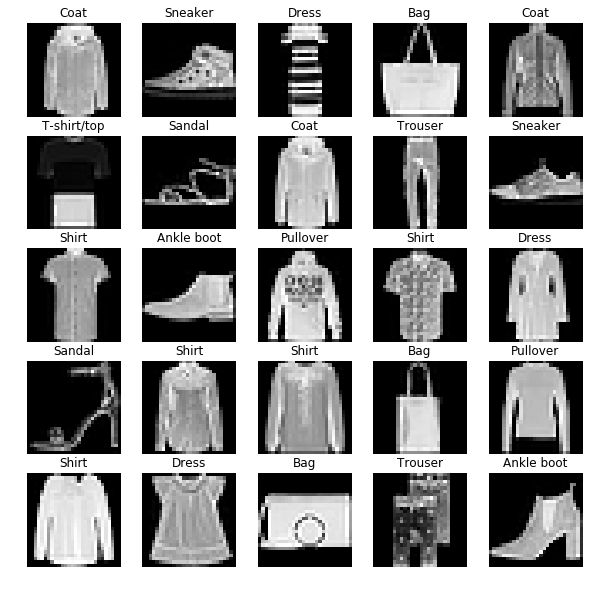

In [4]:
row_img_count = 5

plt.subplots_adjust(wspace=1.5, hspace=2.5)
fig = plt.figure(figsize=(10,10))

batch_size = pow(row_img_count, 2)
train_data_batch = data.train.next_batch(batch_size=batch_size)
for img_id in range(batch_size):
    ax = plt.subplot(row_img_count, row_img_count, img_id+1)
    
    img = train_data_batch[0][img_id].reshape((28,28))
    class_name = class_id_name[train_data_batch[1][img_id]]
    ax.imshow(img , cmap='gray')
    ax.set_title(class_name)
    ax.axes.set_axis_off()

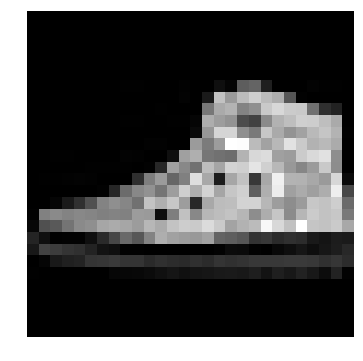

In [5]:
image_id = 1
assert image_id < batch_size
image = train_data_batch[0][image_id].reshape(28,28)

plt.figure(figsize=(6, 6))
plt.imshow(image, cmap='gray')
plt.gca().axes.set_axis_off()

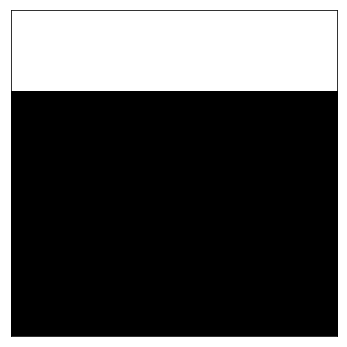

In [6]:
conv_filter = np.array(
    [[1, 1, 1, 1], 
     [0, 0 ,0 ,0], 
     [0 ,0 ,0, 0],
     [0, 0, 0, 0]], dtype=np.float32)

plt.figure(figsize=(6, 6))
plt.imshow(conv_filter, cmap='gray')
ax = plt.gca()
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())


In [7]:
stride_row = 1
stride_col = 1

In [8]:
image_reshaped = image.reshape((1, 28, 28, 1))
conv_filter_shape = conv_filter.shape
conv_filter_reshaped = conv_filter.reshape(conv_filter_shape[0], conv_filter_shape[1], 1, 1)

In [9]:
tf.reset_default_graph()
graph = tf.Graph()
with graph.as_default():
    tf_image = tf.constant(image_reshaped)
    tf_conv_filter = tf.constant(conv_filter_reshaped)
    tf_conv_layer = tf.nn.conv2d(tf_image, 
                                 tf_conv_filter, 
                                 strides=[1, stride_row, stride_col, 1], padding='VALID')

In [10]:
conf = tf.ConfigProto()
with tf.Session(graph=graph) as sess:
    conv_layer = sess.run(tf_conv_layer)[0]

In [11]:
conv_layer_shape = (np.floor((28 - conv_filter_shape[0] + stride_row) / stride_row).astype(int), 
                    np.floor((28. - conv_filter_shape[1] + stride_col) / stride_col).astype(int))
comv_layer_max = conv_layer.max()

def plot_conv_map(tolerance):
    conv_layer_filtered = (conv_layer >= (comv_layer_max - tolerance)).astype(int)
    fig = plt.figure(figsize=(6, 6))
    plt.imshow(conv_layer_filtered.reshape(conv_layer_shape), cmap='gray')
    plt.gca().axes.set_axis_off()
    plt.show()
    
interactive(plot_conv_map, 
            tolerance=ipw.FloatSlider(0.5, min=0.0, max=comv_layer_max-0.1, step=0.01))

interactive(children=(FloatSlider(value=0.5, description='tolerance', max=3.460784578323364, step=0.01), Output()), _dom_classes=('widget-interact',))

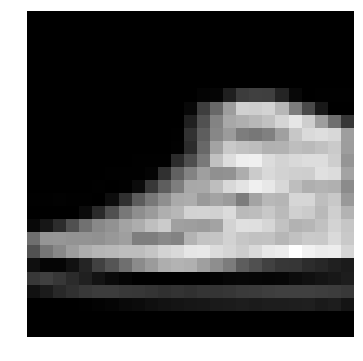

In [37]:
fig = plt.figure(figsize=(6, 6))
plt.imshow(conv_layer.reshape(conv_layer_shape), cmap='gray')
plt.gca().axes.set_axis_off()
plt.show()

In [61]:
def get_conv_control_params(shape, init_mode='diag_pos'):
    controls_params = {}
    for row_id in range(shape[0]):
        for col_id in  range(shape[1]):
            pos_id = str(row_id)+", "+str(col_id)
            if init_mode == 'diag_pos':
                default_value = -1 if row_id + col_id < max(list(shape)) else 1
            elif init_mode == 'diag_neg':
                default_value = 1 if row_id + col_id < max(list(shape)) else -1
            elif init_mode == 'horizon_pos':
                default_value = 1 if row_id < shape[0]/2 else -1
            else:
                default_value = -1 if row_id < shape[0]/2 else 1
            controls_params[pos_id] = ipw.BoundedFloatText(value=default_value, min=-1, max=1, 
                                                           step=0.1, description="", 
                                                           layout=ipw.Layout(width='60px', height='50px'))
    return controls_params

def get_conv_control_widget(widgets_children, shape):
    controls_matrix = list()
    idx = 0
    for row_id in range(shape[0]):
        controls_matrix.append(list())
        for col_id in  range(shape[1]):
            widgets_children[idx].description=''
            controls_matrix[row_id].append(widgets_children[idx])
            idx += 1
    return ipw.VBox([ipw.HBox(m) for m in controls_matrix])



In [67]:
def conv_filter_widget(image, conv_shape=(4,4), stride_row=1, stride_col=1, init_mode='diag_pos'):
    controls_params = get_conv_control_params(conv_shape, init_mode)
    
    def plot_filter(**kwargs):
        conv_filter = np.zeros(conv_shape, dtype=np.float32)

        for row_id in range(conv_shape[0]):
            for col_id in range(conv_shape[1]):
                pos_id = str(row_id)+", "+str(col_id)
                conv_filter[row_id, col_id] = kwargs[pos_id]

        conv_filter_reshaped = conv_filter.reshape(conv_shape[0], conv_shape[1], 1, 1)
        image_reshaped = image.reshape((1, 28, 28, 1))

        tf.reset_default_graph()
        graph = tf.Graph()
        with graph.as_default():
            tf_image = tf.constant(image_reshaped)
            tf_conv_filter = tf.constant(conv_filter_reshaped)
            tf_conv_layer = tf.nn.conv2d(tf_image, tf_conv_filter, strides=[1, stride_row, stride_col, 1], padding='VALID')

        with tf.Session(graph=graph) as sess:
            conv_layer = sess.run(tf_conv_layer)[0]

        conv_layer_shape = (np.floor((28 - conv_shape[0]  + stride_row) / stride_row).astype(int), 
                            np.floor((28 - conv_shape[1] + stride_col) / stride_col).astype(int))


        fig = plt.figure(figsize=(15, 15))
        ax = plt.subplot(2,1,1)
        ax.imshow(conv_layer.reshape(conv_layer_shape))
        ax.axes.set_axis_off()
        ax = plt.subplot(2,1,2)
        ax.imshow(conv_filter)
        ax.axes.set_axis_off()
        plt.show()

    widget = interactive(plot_filter, **controls_params)
    return ipw.VBox([get_conv_control_widget(widget.children[:-1], conv_shape) , widget.children[-1]])

In [68]:
conv_filter_widget(image, (3,3), init_mode='horizon_pos')

VBox(children=(VBox(children=(HBox(children=(BoundedFloatText(value=1.0, layout=Layout(height='50px', width='60px'), max=1.0, min=-1.0, step=0.1), BoundedFloatText(value=1.0, layout=Layout(height='50px', width='60px'), max=1.0, min=-1.0, step=0.1), BoundedFloatText(value=1.0, layout=Layout(height='50px', width='60px'), max=1.0, min=-1.0, step=0.1))), HBox(children=(BoundedFloatText(value=1.0, layout=Layout(height='50px', width='60px'), max=1.0, min=-1.0, step=0.1), BoundedFloatText(value=1.0, layout=Layout(height='50px', width='60px'), max=1.0, min=-1.0, step=0.1), BoundedFloatText(value=1.0, layout=Layout(height='50px', width='60px'), max=1.0, min=-1.0, step=0.1))), HBox(children=(BoundedFloatText(value=-1.0, layout=Layout(height='50px', width='60px'), max=1.0, min=-1.0, step=0.1), BoundedFloatText(value=-1.0, layout=Layout(height='50px', width='60px'), max=1.0, min=-1.0, step=0.1), BoundedFloatText(value=-1.0, layout=Layout(height='50px', width='60px'), max=1.0, min=-1.0, step=0.1))))), Output()))